### Settings & imports

In [1]:
%matplotlib notebook

In [2]:
import sys
mypath = "/home/basia/Documents/spectroscopy/wassersteinms"
sys.path.insert(0, mypath)
import masserstein 

In [3]:
import os

from masserstein import Spectrum, estimate_proportions

from matplotlib import pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap, LogNorm, PowerNorm, AsinhNorm
from matplotlib.ticker import MaxNLocator, LogLocator

import numpy as np

import pulp

import pickle

import seaborn as sns

from textwrap import wrap

from pathlib import Path

import pandas as pd

### Experiments data

In [4]:
components_dictionary = {'experiment_2': ['Pinene', 'Benzyl_benzoate'],
                        'experiment_3': ['Pinene', 'Limonene'],
                        'experiment_4': ['Benzyl_benzoate', 'm Anisaldehyde'],
                        'experiment_5': ['Isopropyl_myristate', 'Benzyl_benzoate', 'Alpha_pinene', 'Limonene'],
                        'experiment_1': ['Pinene', 'Benzyl_benzoate'],
                        'experiment_8': ['Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'],
                        'experiment_6': ['Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'],
                        'experiment_7': ['Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'],
                        'experiment_9': ['Benzyl_benzoate', 'm Anisaldehyde']}

In [5]:
protons_dictionary = {'experiment_2': [16, 12],
                        'experiment_3': [16, 16],
                        'experiment_4': [12, 8],
                        'experiment_5': [34, 12, 16, 16],
                        'experiment_1': [16, 12],
                        'experiment_8': [4, 4, 5, 5, 13],
                        'experiment_6': [4, 4, 5, 5, 13],
                        'experiment_7': [4, 4, 5, 5, 13],
                        'experiment_9': [12, 8]}

In [6]:
ground_truth_molar_proportions = {'experiment_2': [0.09088457406472417, 0.9091154259352758],
                                    'experiment_3': [0.505, 0.495],
                                    'experiment_4': [0.8403875207510383, 0.1596124792489616],
                                    'experiment_5': [0.7264578344443725, 0.10578603326645526, 0.081968804608116, 0.08578732768105625],
                                    'experiment_1': [0.3865, 0.6135],
                                    'experiment_8': [0.3022, 0.2240, 0.1253, 0.2028, 0.1457],
                                    'experiment_6': [0.3022, 0.2240, 0.1253, 0.2028, 0.1457],
                                    'experiment_7': [0.3022, 0.2240, 0.1253, 0.2028, 0.1457],
                                    'experiment_9': [0.3702, 0.6298]}

In [7]:
cwd = Path(os.getcwd())
path = cwd.parent.absolute()

In [8]:
experiments_folders = [name for name in os.listdir(path)
                    if os.path.isdir(os.path.join(path, name)) and str(name).startswith('experiment')]

### Improving heatmaps

In [9]:
experiments_folders

['experiment_3_overlapping',
 'experiment_5_perfumes_and_absent_components',
 'experiment_9_different_solvents',
 'experiment_1_miniperfumes',
 'experiment_2_intensity_difference',
 'experiment_6_and_7_shim',
 'experiment_8_metabolites',
 'experiment_4_overlapping_and_intensity_difference']

In [10]:
experiments_folders = {'experiment_2': 'experiment_2_intensity_difference',
                        'experiment_1': 'experiment_1_miniperfumes',
                        'experiment_8': 'experiment_8_metabolites',
                         'experiment_4': 'experiment_4_overlapping_and_intensity_difference',
                         'experiment_6': 'experiment_6_and_7_shim',
                       'experiment_7': 'experiment_6_and_7_shim',
                        'experiment_9': 'experiment_9_different_solvents',
                        'experiment_5': 'experiment_5_perfumes_and_absent_components',
                         'experiment_3': 'experiment_3_overlapping'}

In [11]:
nr_of_experiment = 9

In [12]:
if (nr_of_experiment != 6 and nr_of_experiment != 7):
    with open(str(path)+'/'+experiments_folders['experiment_'+str(nr_of_experiment)]+'/results_for_different_kappas.pkl', 'rb') as f:
        list_of_dataframes_with_results = pickle.load(f)
else:
    with open(str(path)+'/'+experiments_folders['experiment_'+str(nr_of_experiment)]+'/results_for_different_kappas_exp'+str(nr_of_experiment)+'.pkl', 'rb') as f:
        list_of_dataframes_with_results = pickle.load(f)

In [13]:
molar_proportions = ground_truth_molar_proportions['experiment_'+str(nr_of_experiment)]
protons = protons_dictionary['experiment_'+str(nr_of_experiment)]

In [14]:
temp = []
for nr_of_component, df in enumerate(list_of_dataframes_with_results):
    temp.append(df/protons[nr_of_component])
temp2 = []
for df in temp:
    temp2.append(df/sum(temp))
list_of_dataframes_with_results = temp2
del(temp)
del(temp2)

In [15]:
dataframes_ready_for_heatmap = []
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - molar_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

In [16]:
all_components_results_molar = sum(dataframes_ready_for_heatmap)

In [17]:
if (nr_of_experiment != 6 and nr_of_experiment != 7):
    with open(str(path)+'/'+experiments_folders['experiment_'+str(nr_of_experiment)]+'/results_for_different_kappas.pkl', 'rb') as f:
        list_of_dataframes_with_results = pickle.load(f)
else:
    with open(str(path)+'/'+experiments_folders['experiment_'+str(nr_of_experiment)]+'/results_for_different_kappas_exp'+str(nr_of_experiment)+'.pkl', 'rb') as f:
        list_of_dataframes_with_results = pickle.load(f)

In [18]:
real_visible_proportions = [prot*prop for prot, prop in zip(protons, molar_proportions)]
real_visible_proportions = [prop/sum(real_visible_proportions) for prop in real_visible_proportions]

In [19]:
dataframes_ready_for_heatmap = []
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - real_visible_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

In [20]:
all_components_results_vis = sum(dataframes_ready_for_heatmap)

In [21]:
#all_components_results_both = (all_components_results_vis + all_components_results_molar)/2
#DELIBERATELY CHANGING TO TAKE INTO ACCOUNT ONLY ,,MOLAR'' ERROR IN HEATMAPS
all_components_results_both = all_components_results_molar

In [22]:
all_components_results_both = all_components_results_both.apply(pd.to_numeric, errors = 'coerce', axis=0)

In [23]:
all_components_results_both.min().min()

1.8046798327175928e-05

<IPython.core.display.Javascript object>


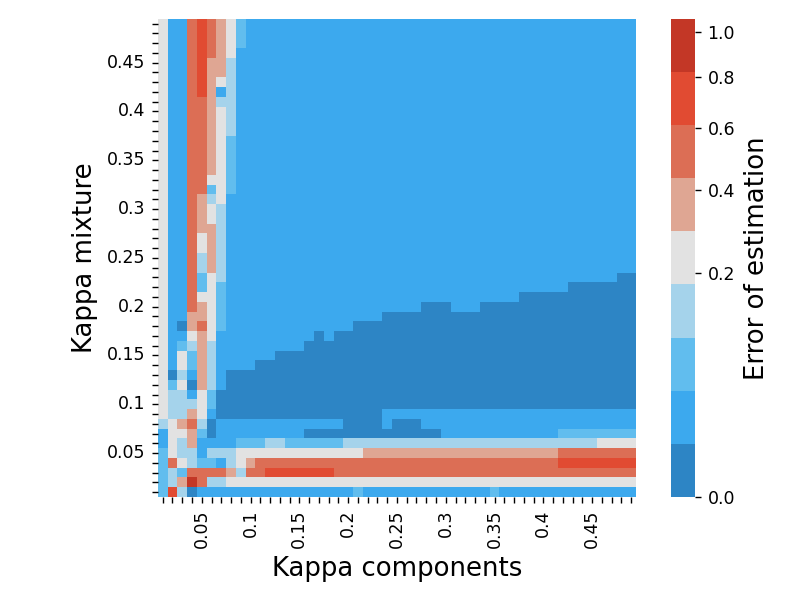

In [34]:
colors = ['#2D85C5', '#3CA9EE', '#61BDEE', '#A5D3EB',\
          '#E2E2E2', '#DFA693', '#DC6E55', '#E14B32', '#C33726']

#powers_in_power_norm = [0.28, 0.33, 0.8, 0.58, 0.75, 0.65, 0.55, 0.39, 0.342]
powers_in_power_norm = [0.5, 0.45, 1.5, 0.525, 1.3, 0.65, 0.65, 0.6, 0.455]

vmin = all_components_results_both.min().min()
vmax = all_components_results_both.max().max()

my_cmap = ListedColormap(colors)
#bounds = [x**1.26 for x in list(np.arange(vmin, vmax, step=(vmax-vmin)/len(colors)))+[vmax]] 
#my_norm = BoundaryNorm(bounds, ncolors=len(colors))
#my_norm = PowerNorm(0.54256, 0, vmax)
my_norm = PowerNorm(powers_in_power_norm[nr_of_experiment-1], vmin, vmax)


labels = [round(x,3) for x in dataframes_ready_for_heatmap[0]]

ax = sns.heatmap(all_components_results_both.astype(float), yticklabels=labels, cbar=True,
                square=True, vmin=vmin, vmax=vmax, xticklabels = labels,
                cmap=my_cmap, norm=my_norm, cbar_ax=None)

ax.invert_yaxis()

for ind, label in enumerate(ax.get_xticklabels()):
    if (ind+1) % 5 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
        
for ind, label in enumerate(ax.get_yticklabels()):
    if (ind+1) % 5 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

cbar = ax.collections[0].colorbar
cbar.set_label('Error of estimation', fontsize=15, labelpad=5)
# minorticks = [0.1, 0.2]
# cbar.ax.yaxis.set_ticks(minorticks, minor=True)

plt.xlabel("Kappa components", fontsize=15, labelpad=5)
plt.ylabel("Kappa mixture", fontsize=15, labelpad=5)

plt.tight_layout()
plt.show()
plt.savefig('heatmap_experiment_'+str(nr_of_experiment)+'.png', dpi=300)

### Averaged heatmaps

In [35]:
all_components_results_both.shape

(49, 49)

In [36]:
rows_beginning = [0]*9
#rows_end = [29, 30, 29, 50, 50, 30, 30, 30, 49]
rows_end = [50, 29, 30, 29, 50, 30, 30, 30, 49]
#kernel_sizes = [3, 6, 6, 10, 10, 3, 6, 6, 10]
kernel_sizes = [10, 3, 6, 6, 10, 6, 6, 3, 10]

In [37]:
rows_to_cut_beginning = rows_beginning[nr_of_experiment-1]
rows_to_cut_end = rows_end[nr_of_experiment-1]
kernel_size = kernel_sizes[nr_of_experiment-1]

In [38]:
import numpy as np
import skimage.measure

a = np.array(all_components_results_both.iloc[rows_to_cut_beginning:rows_to_cut_end, 
                                              rows_to_cut_beginning:rows_to_cut_end])
res = skimage.measure.block_reduce(a, (kernel_size, kernel_size), np.mean)

In [39]:
a.shape

(49, 49)

In [40]:
res.shape

(5, 5)

<IPython.core.display.Javascript object>


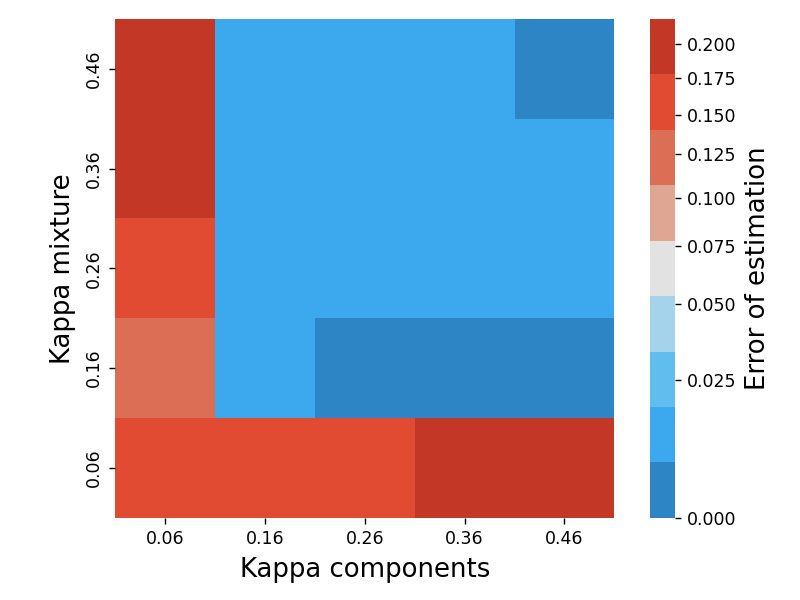

In [41]:
colors = ['#2D85C5', '#3CA9EE', '#61BDEE', '#A5D3EB',\
          '#E2E2E2', '#DFA693', '#DC6E55', '#E14B32', '#C33726']

powers_in_power_norm_av = [0.37, 0.29, 2, 0.7, 0.85, 0.65, 0.55, 0.6, 0.545]


vmin = res.min().min()
vmax = res.max().max()

my_cmap = ListedColormap(colors)
#bounds = [x**1.26 for x in list(np.arange(vmin, vmax, step=(vmax-vmin)/len(colors)))+[vmax]] 
#my_norm = BoundaryNorm(bounds, ncolors=len(colors))
my_norm = PowerNorm(powers_in_power_norm_av[nr_of_experiment-1], vmin, vmax)


labels = [round(x,3) for x in dataframes_ready_for_heatmap[0].iloc[rows_to_cut_beginning:rows_to_cut_end,
                                                                   rows_to_cut_beginning:rows_to_cut_end]][int(np.ceil(kernel_size/2))::kernel_size]

ax = sns.heatmap(res.astype(float), yticklabels=labels, cbar=True,
                square=True, vmin=vmin, vmax=vmax, xticklabels = labels,
                cmap=my_cmap, norm=my_norm, cbar_ax=None)
                #bar_kws={'ticks': MaxNLocator()})
#ax.figure.axes[-1].yaxis.label.set_size(15)
ax.invert_yaxis()

# for ind, label in enumerate(ax.get_xticklabels()):
#     if (ind+1) % 5 == 0:  # every 10th label is kept
#         label.set_visible(True)
#     else:
#         label.set_visible(False)
        
# for ind, label in enumerate(ax.get_yticklabels()):
#     if (ind+1) % 5 == 0:  # every 10th label is kept
#         label.set_visible(True)
#     else:
#         label.set_visible(False)

cbar = ax.collections[0].colorbar
cbar.set_label('Error of estimation', fontsize=15, labelpad=5)
# minorticks = [0.02, 0.025, 0.03, 0.035, 0.04]
# cbar.ax.yaxis.set_ticks(minorticks)
            
# cbar.ax.set_yticklabels(["{:4.2f}".format(i) for i in v1]) # add the labels



plt.xlabel("Kappa components", fontsize=15, labelpad=5)
plt.ylabel("Kappa mixture", fontsize=15, labelpad=5)

plt.tight_layout()
plt.show()
plt.savefig('averaged_heatmap_experiment_'+str(nr_of_experiment)+'.png', dpi=300)